In [1]:
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
map_img = io.imread("data/my_map.png")


#map_img = map_img /255

In [3]:
with open("data/datasetmymap(90-130,40-80)_unidir.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()

with open("data/datasetmymap(3-123,60-64)_unidir.csv", "r") as data:
    laser_db_2 = pd.read_csv(data, delimiter=";").copy()

#laser_db = laser_db.reindex(columns=["cnt","time","angle","range","pos_y","pos_x","pos_yaw"])

#laser_db["pos_x"]= laser_db["pos_x"].mul(-1).add(21.4)

In [4]:
trail = []
for i in laser_db.values:
    if i[2] == 0:
        trail.append(i[4:6])

In [5]:
trail_target = []
c=1
for i in laser_db_2.values:
    if i[0] == c:
        trail_target.append(i[4:6])
        c+=1

#print on map of the trail (or trail_target)

In [6]:
for i in trail:
    x = int(i[0] // 0.05) #288
    y = int(i[1] // 0.05) #428-int(i[1] // 0.05) #428
    map_img[y][x] = 50

IndexError: index 1799 is out of bounds for axis 0 with size 130

In [80]:
x=int(target_xy[0]//0.05)
y=int(target_xy[1]//0.05)
map_img[y][x] = 50

In [25]:
dict_img= {}

for i in map_img:
    for j in i:
        if j in dict_img.keys():
            dict_img[j]+=1
        else:
            dict_img[j]=1

dict_img

{0: 1257, 127: 2332, 254: 15911}

In [65]:
with open('imgnotnorm(nowalls).csv', 'w') as f:
    for i in range(len(map_img)):
        for j in range(len(map_img[i])):
            f.write("{};".format(map_img[i][j]))
        f.write("\n")

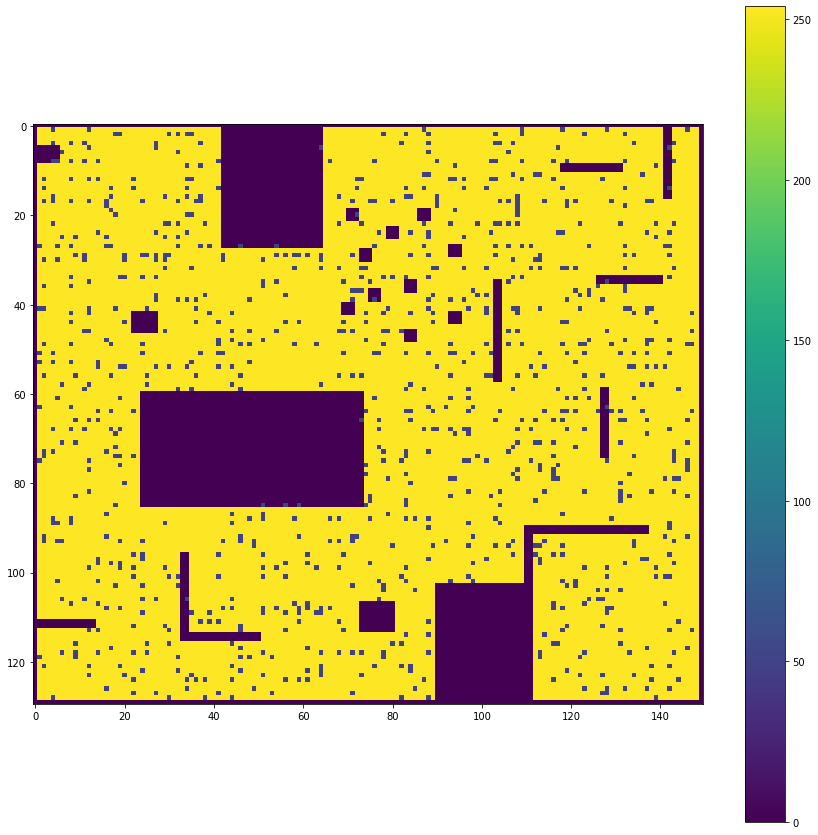

In [24]:
plt.figure(figsize=(15,15))
plt.imshow(map_img)
plt.colorbar()
plt.grid(False)
plt.show()

#test artificial lidar

In [6]:
#get one point of the trail_target
target_db_inst = laser_db_2.values[(3*720)]

target_xy = target_db_inst[4:6]

In [7]:
min_dist = 0.5
j = 1
result_pnt = []
cnt = []

for i in trail:
    dist = np.sqrt(np.power((i[0]-target_xy[0]),2)+np.power((i[1]-target_xy[1]),2))
    if dist < min_dist:
        result_pnt.append(i)
        cnt.append(j)
    j +=1



In [8]:
laser_inst_db = []
laser_inst_target = []

In [9]:
inst = []

for c in cnt:
    c = cnt[0]

    for i in laser_db.values:
        if i[0] == c:
            inst.append([i[2],i[3]])

    laser_inst_db.append(inst)

#if len(cnt) == 1:
#laser_inst_db = laser_inst_db[0]

In [10]:
for i in laser_db_2.values:
    if (i[4] == target_xy[0]) and (i[5] == target_xy[1]):
        laser_inst_target.append([i[2],i[3]])

for i in laser_inst_target:
    if i[1] == np.inf:
        i[1] = 20

In [34]:
def create_lidar(x, y, r, map):
    #correzione assi
    x=427-x
    r=r-180

    if map[x][y] != 254:
        return None
    else:
        #crea una instanza lidar artificiale in base ai pixel vicini
        result = look_around(map,x,y,r,int(20/0.05))
        return result

def look_around(map,x,y,r,dist):
    result = {}

    for i in range(720):
        angle = ((i + r) % 720)
        lidar_range = get_range(map, x, y, np.radians((angle)/2),dist)
        result["range{}".format(i)] = lidar_range*0.05
        result["angle{}".format(i)] = np.around(np.radians((i-360)/2),decimals=5)    

    return result

def get_range(map,x,y,rad,dist):

    for i in range(dist):
        x_range = np.cos(rad) * i
        y_range = np.sin(rad) * i
        if map[x+int(x_range)][y+int(y_range)] != 254:
            break

    if map[x+int(x_range)][y+int(y_range)] == 0:
        
        return min(np.sqrt((np.power(int(x_range),2))+(np.power(int(y_range),2))), dist)
    
    return dist

In [38]:
x = int(target_db_inst[5]//0.05)
y = int(target_db_inst[4]//0.05)

#(np.degrees(target_db_inst[6])*2)

laser_inst_db = []
laser_inst_db_raw = create_lidar(x,y,0,map_img)

for i in range(720):
    temp = []
    temp.append(laser_inst_db_raw["angle{}".format(i)])
    temp.append(laser_inst_db_raw["range{}".format(i)])
    laser_inst_db.append(temp)

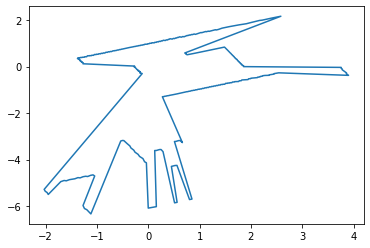

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [21]:
test_laser_db=[]
test_laser_target=[]
test_laser_difference = []

corr_angle = 595

for i in range(720):
    angle = (i-360)/2
    #test_laser_db.append([(np.cos(np.radians(angle))*laser_inst_db[(i+corr_angle)%720][1]),(np.sin(np.radians(angle))*laser_inst_db[(i+corr_angle)%720][1])])
    test_laser_target.append([(np.cos(np.radians(angle))*laser_inst_target[i][1]),(np.sin(np.radians(angle))*laser_inst_target[i][1])])
    #cos_diff = np.cos(np.radians(angle))*(laser_inst_db[(i+corr_angle)%720][1] - laser_inst_target[i][1])
    #sin_diff = np.sin(np.radians(angle))*(laser_inst_db[(i+corr_angle)%720][1] - laser_inst_target[i][1])
    #test_laser_difference.append([cos_diff,sin_diff])

test_laser_db = np.array(test_laser_db)
test_laser_target = np.array(test_laser_target)
test_laser_difference = np.array(test_laser_difference)

plt.plot(test_laser_target[:,0],test_laser_target[:,1])
plt.show()
plt.plot(test_laser_db[:,0],test_laser_db[:,1])
plt.show()

plt.plot(test_laser_difference[:,0],test_laser_difference[:,1])
plt.show()


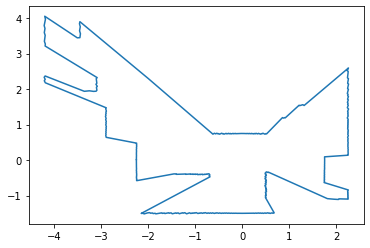

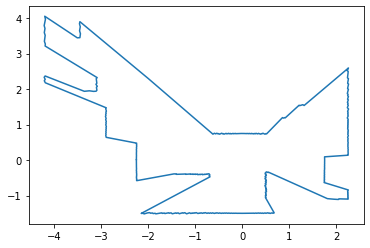

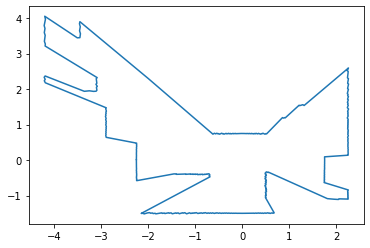

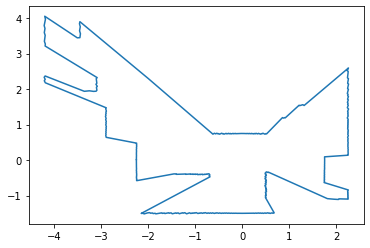

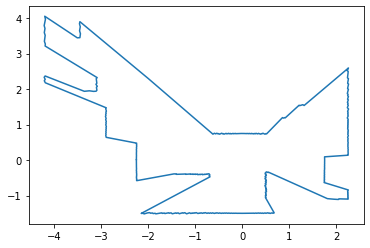

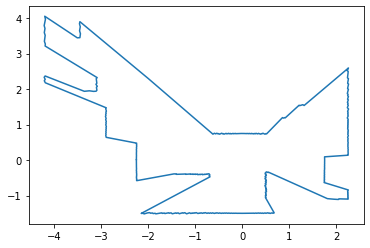

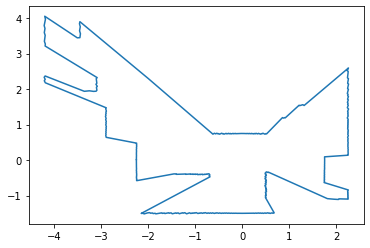

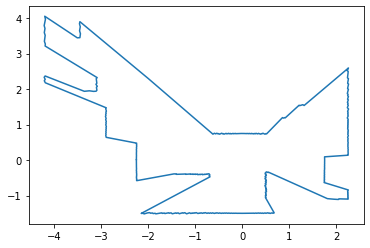

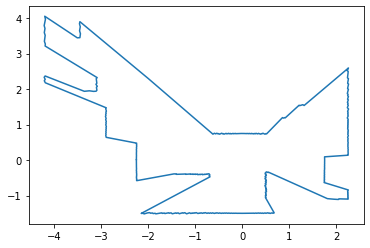

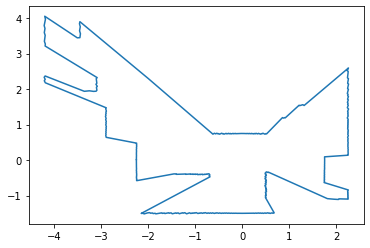

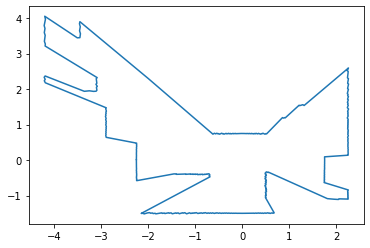

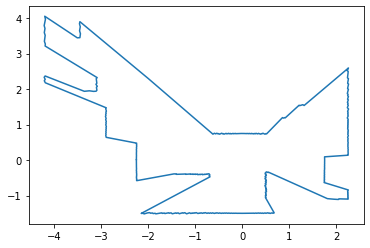

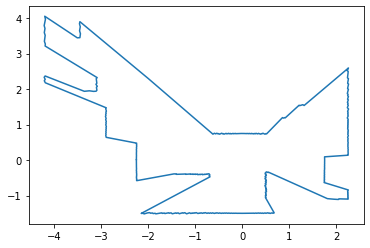

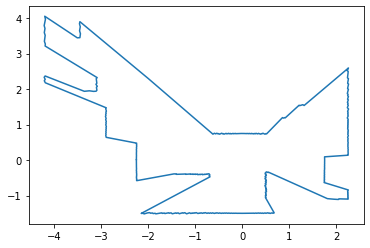

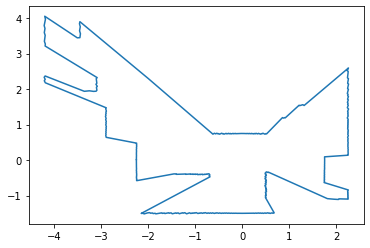

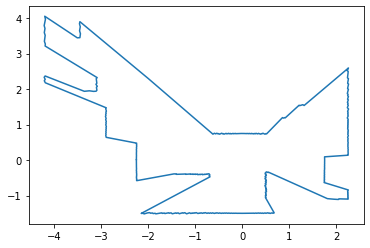

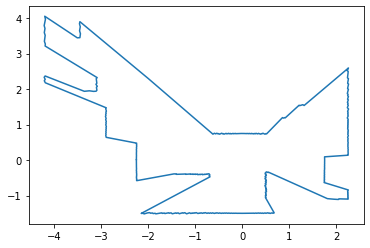

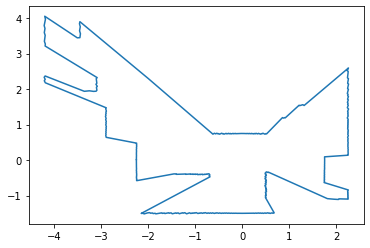

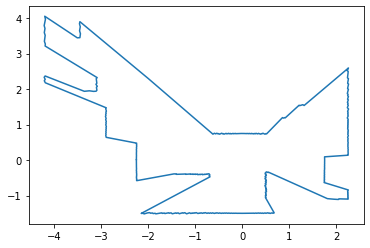

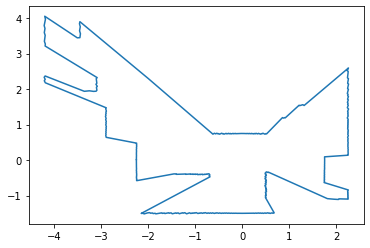

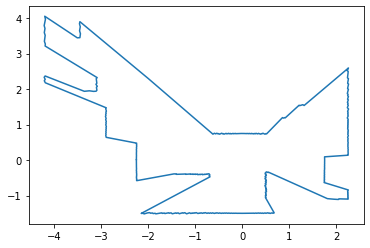

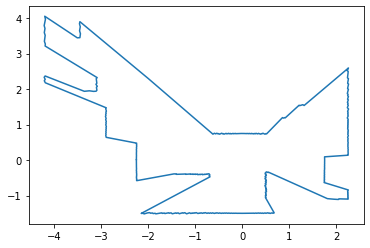

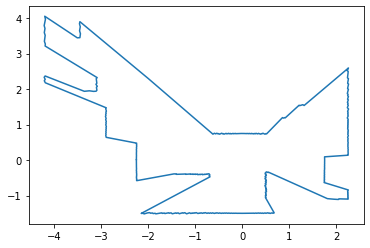

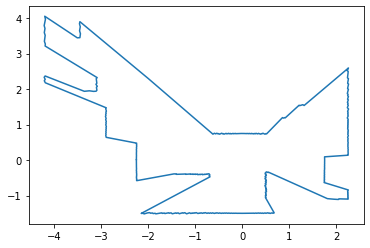

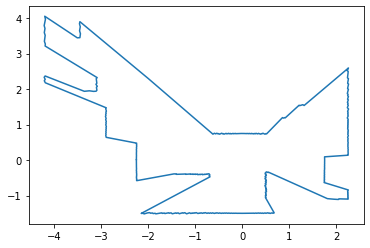

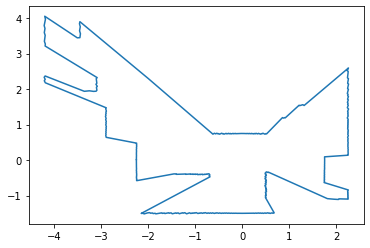

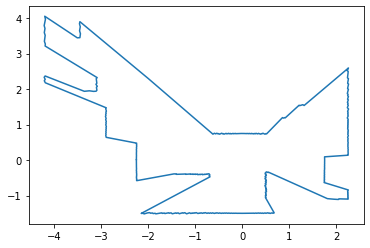

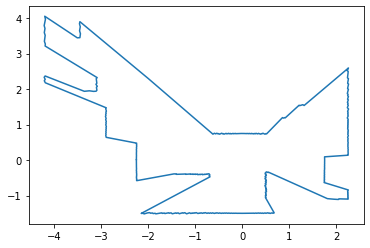

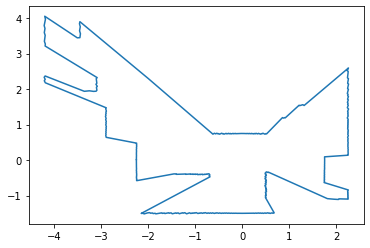

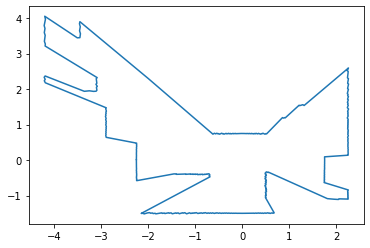

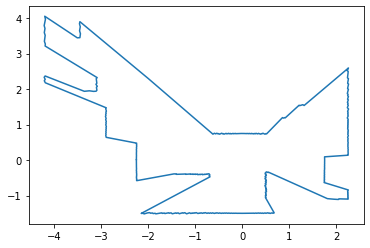

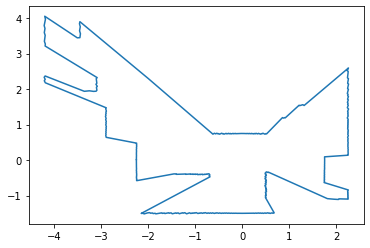

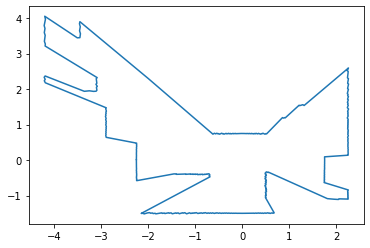

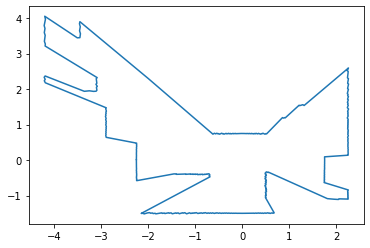

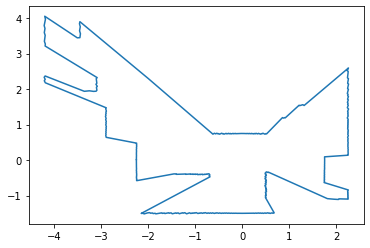

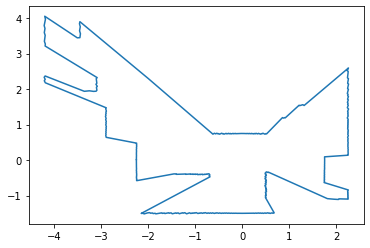

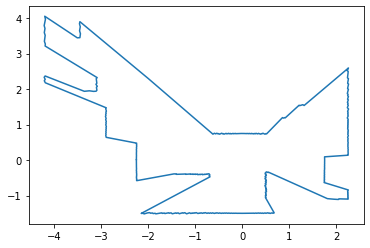

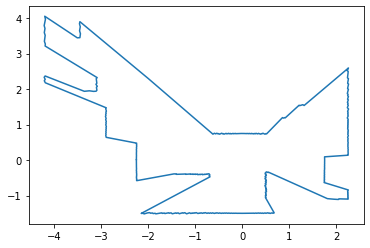

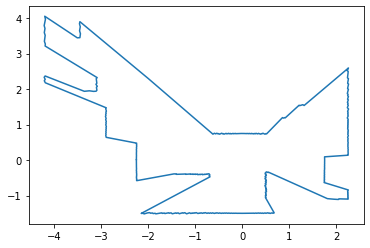

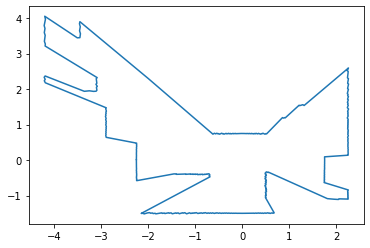

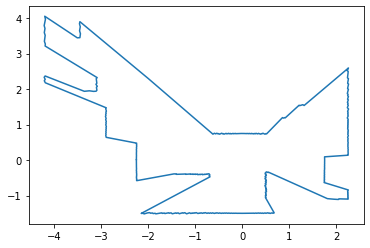

In [12]:

for laser in laser_inst_db:
    test_laser_target=[]

    for i in range(720):
        angle = (i-360)/2
        test_laser_target.append([(np.cos(np.radians(angle))*laser[i][1]),(np.sin(np.radians(angle))*laser[i][1])])

    test_laser_target = np.array(test_laser_target)

    plt.plot(test_laser_target[:,0],test_laser_target[:,1])
    plt.show()


In [23]:
test_laser_difference = []

for c in range(720):
    sum_diff = 0
    
    for i in range(720):
        angle = (i-360)/2
        cos_diff = np.cos(np.radians(angle))*(laser_inst_db[(i+c)%720][1] - laser_inst_target[i][1])
        sin_diff = np.sin(np.radians(angle))*(laser_inst_db[(i+c)%720][1] - laser_inst_target[i][1])
        sum_diff += np.abs(cos_diff) + np.abs(sin_diff)

    test_laser_difference.append(sum_diff)

print(np.argmin(test_laser_difference))



595


In [ ]:
laser_inst_target = np.array(laser_inst_target)
laser_inst_db = np.array(laser_inst_db)

#plt.plot(laser_inst_db[:,0], laser_inst_db[:,1],label="db")
#plt.plot(laser_inst_target[:,0], laser_inst_target[:,1], label="target")
#plt.legend()
#plt.show()

for i in laser_inst_db:
    i = np.array(i)
    plt.plot(i[:,0], i[:,1])
    plt.plot(laser_inst_target[:,0], laser_inst_target[:,1])
    plt.show()

In [13]:
for i in result_pnt:
    x = int(i[0] // 0.05) #288
    y = 428-int(i[1] // 0.05) #428
    map_img[y][x] = 205

x = int(target_xy[0] // 0.05) #288
y = 428-int(target_xy[1] // 0.05) #428
map_img[y][x] = 0

In [ ]:
plt.figure(figsize=(30,30))
plt.imshow(map_img)
plt.colorbar()
plt.grid(False)
plt.show()

In [45]:
with open('datasetnowall.csv', 'w') as f:
    f.write("cnt;time;angle;range;pos_x;pos_y;pos_yaw\n")
    for item in laser_db.values:
        
        f.write("{};{};{};{};{};{};{}\n".format(item[0],item[1],item[2],item[3],item[4],item[5],item[6]))
        

#Save an image from numpy array

In [3]:
with open("my_map.csv", "r") as data:
    map_csv = pd.read_csv(data, delimiter=";").copy()

map_csv = map_csv*254

In [4]:
from PIL import Image
import numpy as np

img = Image.fromarray(map_csv.values.astype(np.uint8))
img.save("my_map.png")